<h1>Quantum Signal Processing</h1>

<i>Justin E. Elenewski (MIT-LL)</i> <b>:</b> <i>Code Revision 07/27/2022</i>

<h2> Distribution Statement </h2>

DISTRIBUTION STATEMENT A. Approved for public release. Distribution is unlimited.

<br>
This material is based upon work supported by the Under Secretary of Defense for
Research and Engineering under Air Force Contract No. FA8702-15-D-0001. Any opinions,
findings, conclusions or recommendations expressed in this material are those of the
author(s) and do not necessarily reflect the views of the Under Secretary of Defense
for Research and Engineering.

<br>
© 2022 Massachusetts Institute of Technology.

<br>
<br>
The software/firmware is provided to you on an As-Is basis

<br>
<br>
Delivered to the U.S. Government with Unlimited Rights, as defined in DFARS Part
252.227-7013 or 7014 (Feb 2014). Notwithstanding any copyright notice, U.S. Government
rights in this work are defined by DFARS 252.227-7013 or DFARS 252.227-7014 as detailed
above. Use of this work other than as specifically authorized by the U.S. Government
may violate any copyrights that exist in this work.

This notebook implements quantum signal processing (QSP) at a high-order "gate-free" level.  These methods are intended to be useful for both pedagogical purposes and  algorithm development. The notation and formal constructs generally parallel my "A User's Guide to Quantum Signal Processing and the Quantum Singular Value Transformation," though certain key points are recapitulated as needed.

In brief, the methods herein deliver complex-valued polynomial transformations $P(\Lambda), Q(\Lambda)$ of some normal operator $\Lambda$ (or matrix) using a QSP sequence:


\begin{equation}\label{eq:qsp_form_o}
\begin{split}
\mathcal{O}_{\vec{\phi}} &= e^{\imath\phi_0 \, Z_\Pi} \prod_{k=1}^d \left[U_\Lambda Z_\Pi e^{\imath\phi_k \, Z_\Pi}\right] \\
&= e^{\imath\phi_0 \, Z} \prod_{k=1}^d \left[R(\Lambda) e^{\imath\phi_k \, Z}\right] = \begin{pmatrix} P(\Lambda) & Q(\Lambda) \\ Q^\dagger(\Lambda) & P(\Lambda)  \end{pmatrix}.
\end{split}
\end{equation}

This sequence is assembled from several constituents, including a minimal unitary block encoding $U_\Lambda$ for $\Lambda$ that is given by,

\begin{equation}
U(\Lambda) =\begin{pmatrix} \Lambda & \sqrt{1-\Lambda^2} \\ \sqrt{1 - \Lambda^2} & -\Lambda^\dagger, \end{pmatrix},  \hspace{40pt} \Lambda = \big(\langle G | \otimes I_n\big) \, U_\Lambda \, \big(| G \rangle \otimes I_n\big).
\end{equation} 

This allows us to access our target operator $\Lambda$ using a qubitized signal state $|G\rangle$.  While practical implementations will take  $|G\rangle$ to be a set of $m$-ancilla $|G\rangle \equiv |0^m\rangle$ in a so-called control register (which ultimately manipulate select and prepare oracles), we are free to use a single ancilla  $|G\rangle = |0\rangle$ in this gate-free implementation.  Furthermore, the qubitized reflection $Z_\Pi$ and rotation operators $Z_{\Pi,\phi}$ are respectively equivalent to the pauli $Z$ operator and a $z$-rotation when dealing with a single ancilla.   The product $R(\Lambda) = U_\Lambda \cdot Z$ defines an SU(2) $y$-rotation operator  which acts in our qubitized Hilbert space.

During QSP, the $y$-rotation $R(\Lambda)$ defined above is interleaved with a cascade of $z$-rotations, each specified by a given phase angle $\{\phi_0, \dots, \phi_d\}$.  These angles are calculated (using classical fitting routes) to reproduce our target polynomal transformations:



\begin{equation}
\begin{split}
\mathcal{O}_{\vec{\phi}} = e^{i \phi_0 \hat{Z}}\, R \, e^{i \phi_1 \hat{Z}}\,  R \,  \dots \,  R  \, e^{i \phi_d \hat{Z}}\, = \begin{pmatrix} P(\Lambda) & Q(\Lambda) \\ Q^\dagger(\Lambda) & P(\Lambda)  \end{pmatrix}
\end{split}
\end{equation}

While this expression is equivalent those at the beginning of our dicussion, it is helpful to see the explicit cascade.  This sequence is precisely the quantity that our code computes.

<h2>Numerical Results</h2>

<h3>Quick Demonstration</h3>

We begin by loading routines from the `qspsim` module, though several helpful accessory functions are also contained within the `vlasovsim` module (<i>Note: these should probably be split out into a separate module at some point</i>).

In [1]:
import inspect

import numpy                as np
import numpy.linalg         as nla
import scipy.linalg         as sla

import pyLIQTR.model_simulators.vlasovsim    as vs
import pyLIQTR.model_simulators.qspsim       as qsp

import matplotlib.pyplot    as plt


For demonstrative purposes, we define a simple 'toy' Hamiltonian for QSP.  A good test is the three-site ($N=3$) transverse-field Ising model,

\begin{equation}
H = J\sum_{i=1}^{N-1} Z_i \otimes Z_{i+1} + g \sum_{i=1}^N X_i,
\end{equation}

which we define using several helpful methods from `vlasovsim`:

In [2]:

J = -0.1
g = 0.25

H = J*(vs.multikron((vs.pz,vs.pz,vs.id)) + vs.multikron((vs.id,vs.pz,vs.pz))) + \
     g*(vs.multikron((vs.px,vs.id,vs.id)) + vs.multikron((vs.id,vs.px,vs.id)) + \
       vs.multikron((vs.id,vs.id,vs.px)))


We need to ensure that the norm of the Hamiltonian $\Lambda \equiv H$ is consistent with a contractive operator $|| \Lambda || \leq 1$, as required for existence of a block encoding (similarly that the eigenvalues $\lambda \in [-1,1]$).  While the values of $J$ and $g$ adopted above ensure that this will be true, we can always rescale $H$ by a constant $\alpha$ if necessary.

In [3]:

ham_eigs = nla.eigvals(H).real
ham_eigs


array([ 0.76999232, -0.76999232,  0.40038104, -0.40038104,  0.11961128,
       -0.11961128,  0.25      , -0.25      ])

In [4]:

(np.sqrt(max(ham_eigs)) <= 1.0)


True

The reference implementation of QSP from this notebook assumes that we use $|+\rangle$ as our signal state.  As such, we combine this with the identity operator $I_n$ on the three system qubits in the domain of $H$:

In [5]:

sig    = (1.0 / np.sqrt(2.0))*np.array([1,1])

sig_id = vs.multikron((sig,vs.id,vs.id,vs.id))


The `qspsim` module conatins a routines that allow us to explicitly define the block encoding (as we will demonstrate below).  In the meantime, there is a precanned routine in `qspsim`  that computes $\exp[-\imath \delta t \cdot H]$ for $\delta t = 10$ as a quick validation.  The aformentioned block encoding is given by:

In [6]:

Ut_block_qsp = qsp.qsp_exp_sim_r(H)


and the target operator may be accessed by taking the inner product with the signal state,

In [7]:

Ut_qsp       = vs.ip_sv_expect(sig_id.T,Ut_block_qsp,sig_id.T) 


We can compare this to an explicit calculation of the matrix exponential:

In [8]:

Ut_exact = sla.expm(-10.0j*H)


and quantify how well the QSP propagator `Ut_block_qsp` reproduces this exact result `Ut_qsp` by calculating the trace-distance between their matrix representations:

In [9]:

qsp.trace_distance(Ut_qsp,Ut_exact).real


0.019872984692717942

This is on par with what we expect for the $\epsilon \approx 10^{-2}$ encoding that is delivered by the included phase angle sequence.

<h3>A Few More Details...</h3>

The `qspsim` routines allow more finely-grained control than implied above.  In particular, we can quickly calculate the explicit reflection operators $U_H$ = `Ua`, $Z_\Pi$ = `ZPi` for the QSP sequence, as well as the qubitized identity operator `Id`, by using the routine `get_qsp_operators_r()`:




In [10]:

Ua,ZPi,IdM = qsp.get_qsp_operators_r(H)


Moreover, we can compute the $y$-rotation $R(H) = $ `Rot` from the QSP sequence:

In [11]:

Rot = np.matmul(Ua,ZPi)


Taking these components together - alongside a set of phase angles that specify our target function - we can calculate the full QSP sequence using `qsp_sequence()`.  We demonstrate this below using precomputed angles (`phaseCos1x`, `phaseSin1x`) that reproduce $\sin(\delta t H)$ and $\cos(\delta t H)$ for $\delta t = 1.0$:


In [12]:

op_cos = qsp.qsp_sequence(Rot,ZPi,qsp.phaseCos1x)
op_sin = qsp.qsp_sequence(Rot,ZPi,qsp.phaseSin1x)


These specific angles were computed using the Laurent polynomial method from `pyqsp` package of Isaac Chuang (https://github.com/ichuang/pyqsp). Nonetheless, any determination in the "R"-formalism of QSP will suffice (and any other convention may be adopted to this through an appropriate shift of phase angles).  Higher precision is available through optimization-based methods, which we include in a separate module.

We now combine these components to obtain the exponential $\exp(-\imath \delta t \cdot H) = \cos(\delta t H) - \imath \sin(\delta t H)$.  This process would be accomplished using controlled operations  in a real, gate-based calculation (which we could certainly do here). For now we simply sum these by hand:

In [13]:

op_cos = op_cos + np.conj(op_cos)
op_sin = op_sin + np.conj(op_sin)

# Generate the qubitized exponential operator
Ut_block_qsp = op_cos - 1j*op_sin


Once again, we extract the representation from our block encoding:

In [14]:

Ut_qsp       = vs.ip_sv_expect(sig_id.T,Ut_block_qsp,sig_id.T) 


And  compare with the direct matrix exponential:

In [15]:

Ut_exact = sla.expm(-1.0j*H)


qsp.trace_distance(Ut_qsp,Ut_exact).real


0.0003946153794341766

We see bettter agreement since the underlying phase angle sequences are now computed as an $\epsilon \approx 10^{-3}$ fit.

<h3>A Quantiative Comparison</h3>

We can make one additional comparison.  Let's try working with the operator

\begin{equation}
Z_x = \begin{pmatrix} x & 0 \\ 0 & -x\end{pmatrix}
\end{equation}

and scrutinize the QSP approximation for several values of $x$.

In [16]:
def Zx(x):
    
    M = np.array([[x,0.0],[0.0,-x]])
    
    return(M)


vals = [x for x in np.linspace(-1.0,1.0,num=128)]

qspr      = np.zeros(len(vals))


for j in range(len(vals)):
    
    Ua,ZPi,IdM = qsp.get_qsp_operators_r(Zx(vals[j]))
    Rot = np.matmul(Ua,ZPi)
    
    op_cos = qsp.qsp_sequence(Rot,ZPi,qsp.phaseCos10x)
    
    op_cos = op_cos + np.conj(op_cos)

    qspr[j]     = (op_cos[0,0]).real


Once again, we plot this versus the exact result:

In [17]:
ref_cos      = np.zeros(len(vals))

for j in range(len(vals)):
    ref_cos[j]  = np.cos(10*vals[j])


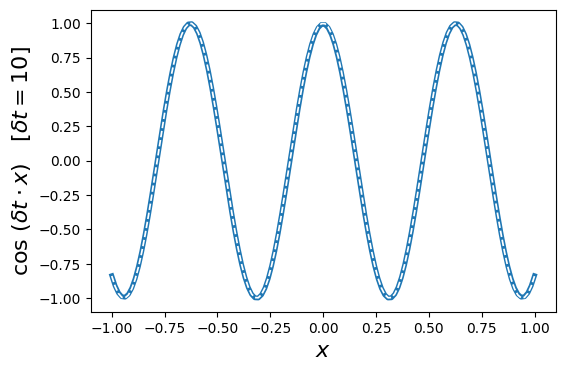

In [26]:
### TODO: Latex error - fix later.

plt.figure(dpi=100)
# plt.rcParams['text.usetex'] = False


plt.plot(vals,qspr, linewidth=3.5)
plt.plot(vals,ref_cos, linestyle="--", linewidth=1.25,color="white")
plt.xlabel(r'$x$',fontsize=16)
plt.ylabel(r'$\cos\,(\delta t \cdot x)$   [$\delta t = 10$]', fontsize=16)

plt.show()

Which shows good qualitative agreement with our expectations.  We also compute the error in the estimate:

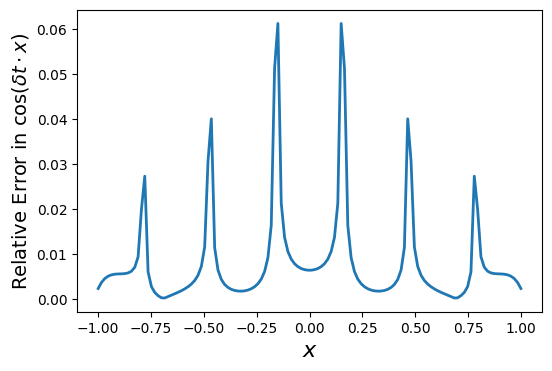

In [25]:

plt.figure(dpi=100)
# plt.rcParams['text.usetex'] = True

err_cos = np.abs((qspr - ref_cos) / ref_cos)

plt.plot(vals,err_cos, linewidth=2.0)
plt.xlabel(r'$x$',fontsize=16)
plt.ylabel(r'Relative Error in $\cos (\delta t \cdot x)$', fontsize=14)

plt.show()

Which lies at $\epsilon \approx 10^{-2}$ for expansion about $x = 0$.

<h2>Plasma Applications: Vlasov-Hermite Hamiltonian</h2>

We can apply the same QSP methods to the Pauli encoding of the Vlasov Hamiltonian,


\begin{equation}
H_V = \frac{1}{2} \sum_{m=0}^{N-2} \sqrt{\frac{1 + m + \alpha \delta_{m,0}}{2}} \big(X_m X_{m+1} + Y_m Y_{m+1} \big)  - \imath \nu \sum_{m=2}^{N-1} m \Big(\frac{I+Z_m}{2}\Big),
\end{equation}

using the tools in the `vlasovsim` module.  We compute the Hamiltonian directly:

In [27]:
N      =  4                                    # Number of terms in the Vlasov-Hermite 
                                               # expansion

k      =  2.0                                  # Fourier wavenumber

nu     =  0.0                                  # Collisional damping parameter
                                               # (for use only with statevector propagation)

alpha  =  0.6                                  # Electric field parameter

Hv_wfn  = vs.hamiltonian_wfn_vlasov_hermite_linear_sym(k,alpha,nu,N)


The norm condition is not met in this case; thus we need to divide by the maximal eigenvalue.  Note that this is equivalent to a rescaling of the time parameter $\delta t$ in the opertor evalution.

In [28]:

max_eig = np.max(sla.eig(Hv_wfn)[0]).real
print("Max. eigenvalue unscaled: \t", max_eig)

Hv_wfn = (Hv_wfn / max_eig).real
print("Max. eigenvalue rescaled: \t",np.max(sla.eig(Hv_wfn)[0]).real)


Max. eigenvalue unscaled: 	 4.686529731057156
Max. eigenvalue rescaled: 	 0.9999999999999999


Once again, we form the signal state and compute the expectation value with respect to the QSP sequence:

In [29]:


sig    = (1.0 / np.sqrt(2.0))*np.array([1,1])
sig_id = vs.multikron((sig,vs.id,vs.id,vs.id,vs.id))


Ut_vlasov_block_qsp   =  qsp.qsp_exp_sim_r(Hv_wfn)
Ut_vlasov_qsp         =  vs.ip_sv_expect(sig_id.T,Ut_vlasov_block_qsp,sig_id.T) 


And compute the exact result for comparison,

In [30]:

Ut_vlasov_exact = sla.expm(-10.0j*Hv_wfn)


thus finding the expected level of agreement via the trace distance:

In [31]:

qsp.trace_distance(Ut_vlasov_qsp,Ut_vlasov_exact).real



0.04015490167892606